# **Cloning The Detectron2 Repository**

In [1]:
%%capture
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# **Decisions/Set Function**

In [2]:
from datetime import datetime

is_train = True                   # if False, model is set to `PRETRAINED_PATH` model
is_evaluate = False               # if True, evaluate on validation dataset
is_inference = True               # if True, run inference on test dataset
is_resume_training = False        # if True and `is_train` == True, `PRETRAINED_PATH` model is trained further
is_augment = False                # Perform augmentation

SEED = int(datetime.now().timestamp())

# **Data Directory**

In [3]:
from pathlib import Path

TRAIN_IMG_DIR = Path("/kaggle/input/fydp-detectron2/train")
TRAIN_COCO_PATH = Path("/kaggle/input/fydp-detectron2/train/_annotations.coco.json")

TEST_IMG_DIR = Path("/kaggle/input/fydp-detectron2/test")
TEST_METADATA_PATH = Path("/kaggle/input/fydp-detectron2/test/_annotations.coco.json")

OUTPUT_DIR = Path("./output")                     # Training output directory
OUTPUT_MODEL = OUTPUT_DIR/"model_final.pth"

PRETRAINED_PATH = Path("")                        # Path to your pretrained model weights

# **Model Path**

In [4]:
MODEL_PATH = OUTPUT_MODEL if is_train else PRETRAINED_PATH

# **Importing Necessary Libraries**

In [5]:
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.utils.logger import setup_logger
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm                      
import matplotlib.pyplot as plt
import json
import cv2
import copy
from typing import Optional
import seaborn as sns

#!pip install -q pycocotools
from pycocotools.coco import COCO
from PIL import Image
import random
from pathlib import Path
%matplotlib inline
sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)

from typing import Optional
from IPython.display import FileLink

import torch                                       
import gc
import warnings
warnings.filterwarnings('ignore')                  

setup_logger()

<_Logger detectron2 (DEBUG)>

# **Labels and Metadata**

In [6]:
with TRAIN_COCO_PATH.open() as f:
    train_dict = json.load(f)

with TEST_METADATA_PATH.open() as f:
    test_dict = json.load(f)
    
train_coco_labels=COCO(annotation_file=TRAIN_COCO_PATH)

print("#### LABELS AND METADATA LOADED ####")

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
#### LABELS AND METADATA LOADED ####


# **Organize Data**

In [7]:
def organize_coco_data(data_dict: dict) -> tuple[list[str], list[dict], list[dict]]:
    thing_classes: list[str] = []

    # Map Category Names to IDs
    for cat in data_dict['categories']:
        thing_classes.append(cat['name'])

    # Images
    images_metadata: list[dict] = data_dict['images']

    # Convert COCO annotations to detectron2 annotations format
    data_annotations = []
    for ann in data_dict['annotations']:
        # coco format -> detectron2 format
        annot_obj = {
            # Annotation ID
            "id": ann['id'],

            # Segmentation Polygon (x, y) coords
            "gt_masks": ann['segmentation'],

            # Image ID for this annotation (Which image does this annotation belong to?)
            "image_id": ann['image_id'],

            # Category Label (0: text-box-images-etc, 1: advertisement, 2: caption, 3: image, 4: page number, 5: paragraph, 6: table, 7: Text, 8: Title)
            "category_id": ann['category_id'],

            "x_min": ann['bbox'][0],                     # left
            "y_min": ann['bbox'][1],                     # top
            "x_max": ann['bbox'][0] + ann['bbox'][2],    # left+width
            "y_max": ann['bbox'][1] + ann['bbox'][3]     # top+height
        }
        data_annotations.append(annot_obj)

    return thing_classes, images_metadata, data_annotations

# **Object's Classes**

In [8]:
thing_classes, images_metadata, data_annotations = organize_coco_data(train_dict)

thing_classes_test, images_metadata_test, _ = organize_coco_data(test_dict)

# **Print All Classes**

In [9]:
print(thing_classes)

['text-box-images-etc', 'advertisement', 'caption', 'image', 'page number', 'paragraph', 'table', 'text', 'title']


# **Organized Metadata (Train)**

In [10]:
train_metadata = pd.DataFrame(images_metadata)
train_metadata = train_metadata[['id', 'file_name', 'width', 'height']]
train_metadata = train_metadata.rename(columns={"id": "image_id"})
print("train_metadata size=", len(train_metadata))
train_metadata.head(5)

train_metadata size= 1845


image_id                                          file_name  width  height
0         0  YugntaraJugantar_5_2_jpg.rf.45b213ac7dd7812fd9...    640     640
1         1  3e6f8443-02c0-4a32-9167-19d45665e911-at1000_jp...    640     640
2         2  edbef5df-7e4d-4f49-a948-87cc4dae73c5-at800_jpg...    640     640
3         3  0428ef17-f4ed-458a-9a02-5ab0f0275573-at1000_jp...    640     640
4         4  f893cca0-6c6c-47e4-825c-5089ae67a51f_png.rf.46...    640     640

# **Organized Annotations (Train)**

In [11]:
train_annot_df = pd.DataFrame(data_annotations)
print("train_annot_df size=", len(train_annot_df))
train_annot_df.head(5)

train_annot_df size= 38701


id                                           gt_masks  image_id  \
0   0  [[322.589, 19.198, 109.753, 16.908, 106.768, 1...         0   
1   1  [[35.193, 45.715, 35.633, 55.127, 37.747, 60.3...         0   
2   2  [[36.074, 94.863, 46.534, 94.973, 70.586, 94.8...         0   
3   3  [[34.827, 120.813, 43.817, 120.907, 44.524, 12...         0   
4   4  [[34.314, 154.716, 39.709, 155.756, 49.277, 15...         0   

   category_id  x_min  y_min    x_max    y_max  
0            3    107     17  322.821  133.210  
1            8     34     20   81.907   63.361  
2            5     33     64  103.767   94.910  
3            5     34     95  104.790  121.263  
4            5     34    120  103.569  155.465

# **Organized Metadata (Test)**

In [12]:
test_metadata = pd.DataFrame(images_metadata_test)
test_metadata = test_metadata[['id', 'file_name', 'width', 'height']]
test_metadata = test_metadata.rename(columns={"id": "image_id"})
print("test_metadata size=", len(test_metadata))
test_metadata.head(5)

test_metadata size= 322


image_id                                          file_name  width  height
0         0  c09227bb-d3fb-483f-9801-8b4aae0f9fd6-at1000_jp...    640     640
1         1  d80b937f-37b3-48b1-88c3-eb25442f5d1b-at1000_jp...    640     640
2         2  mag_2_26_jpg.rf.0a16cc1af95e0f2a5a6a51c10e6d06...    640     640
3         3  db71bb15-ffe6-4bba-a76d-01ad4cd299d7-at800_jpg...    640     640
4         4  a19e1236-61de-48a5-8de2-ca0551e5369c-at800_jpg...    640     640

# **Sample Train Images**

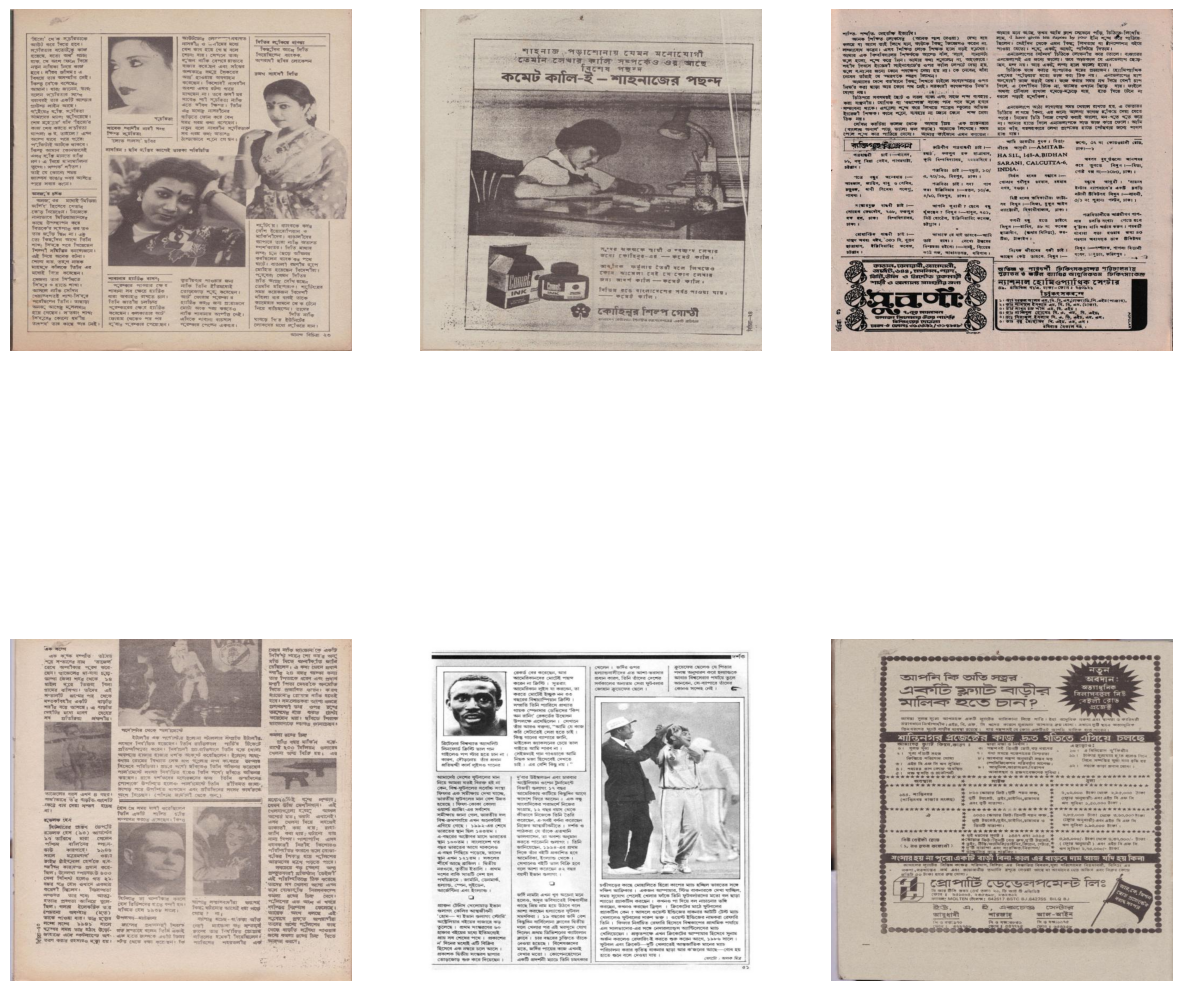

In [13]:
import random

plt.figure(figsize=(15, 15))
for i in range(6):
    image_id = random.randint(2, 364)
    image_file = train_coco_labels.loadImgs([image_id])[0]['file_name']
    image = Image.open(TRAIN_IMG_DIR/image_file)
    code = 231 + i;
    plt.subplot(code)
    plt.axis('off')
    plt.imshow(np.asarray(image))

# **Visualise Image**

In [14]:
def show_image(_image_id):
    image_file = train_coco_labels.loadImgs([_image_id])[0]['file_name']
    image = Image.open(TRAIN_IMG_DIR/image_file)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(np.asarray(image))

# **Visualize Segmentation**

In [15]:
def show_segmentations(_image_id):
    show_image(_image_id)
    annotation_ids = train_coco_labels.getAnnIds(imgIds=[_image_id])
    annotations = train_coco_labels.loadAnns(annotation_ids)
    train_coco_labels.showAnns(annotations)

# **Image and Corresponding Segmentation**

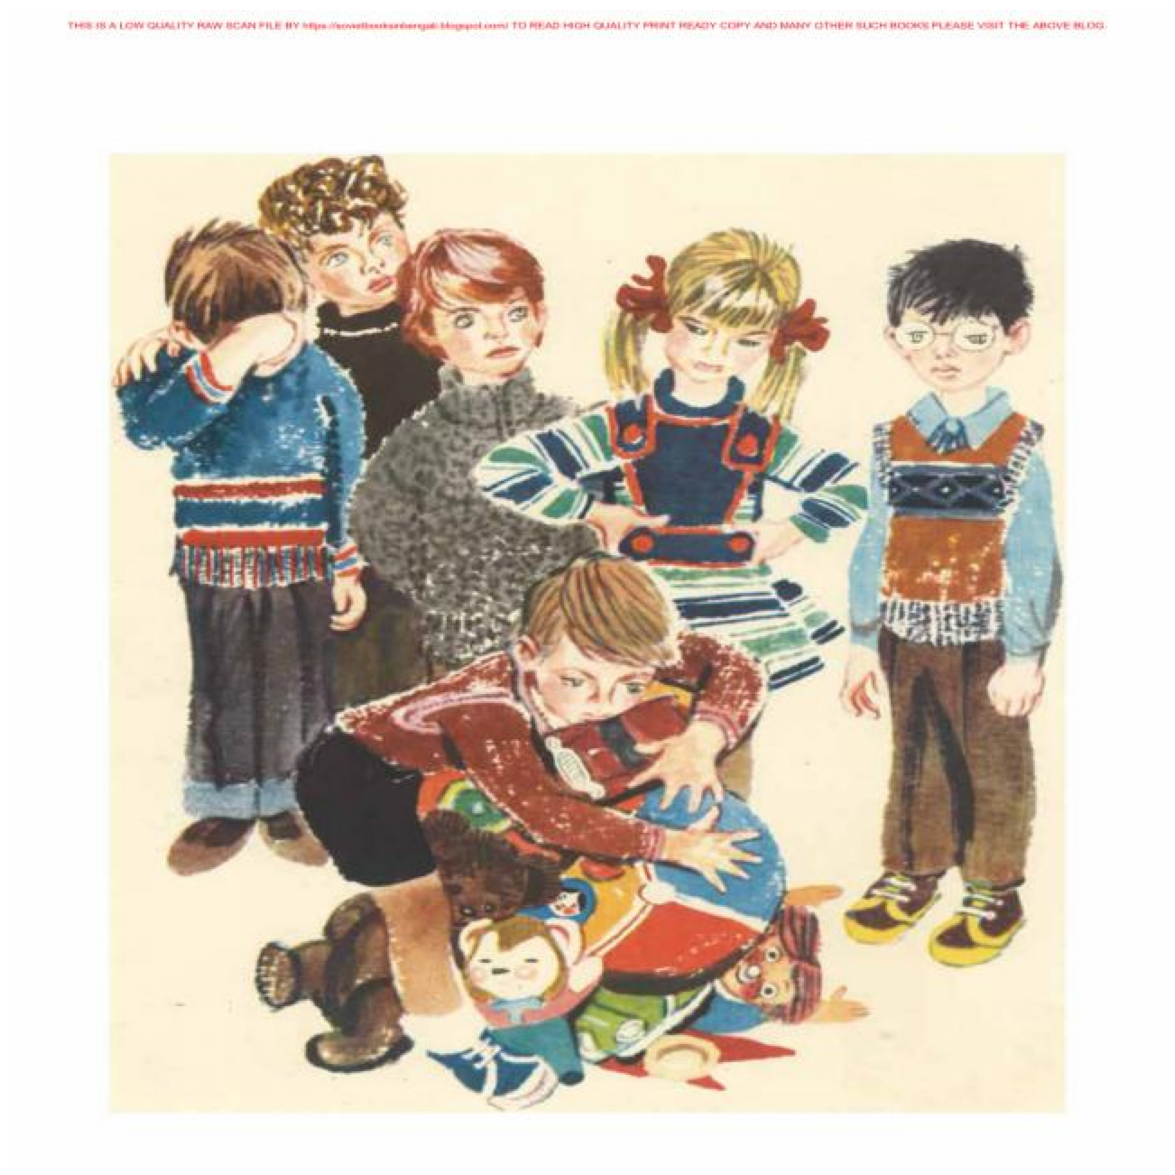

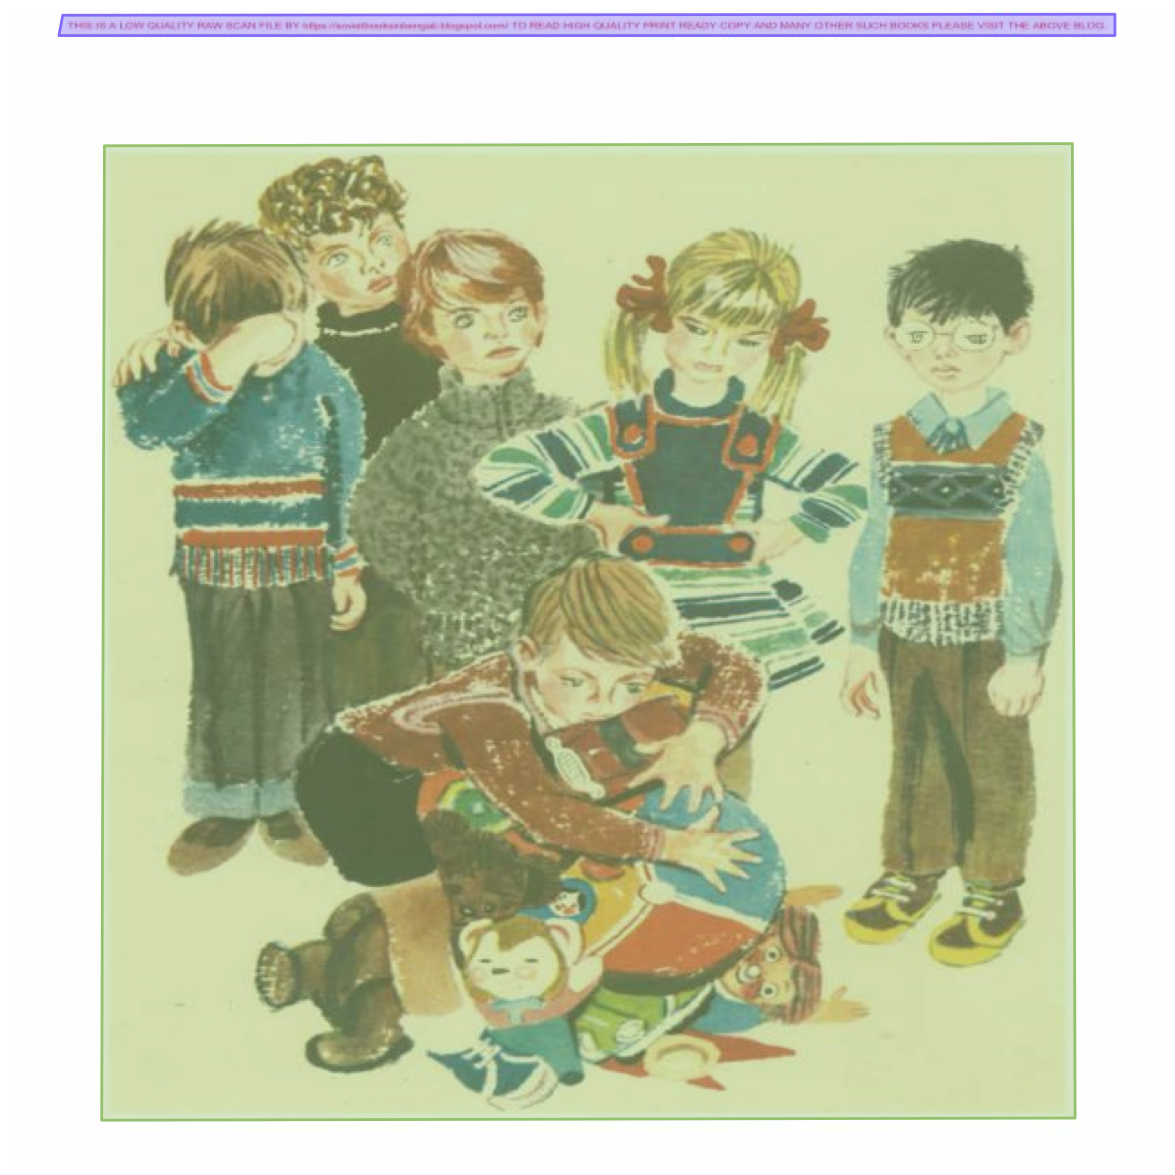

In [16]:
show_image(50)
show_segmentations(50)

# **Categorical Calssification**

In [17]:
train_categories = pd.DataFrame(train_dict['categories'])

print("Dropping supercategory.\nRenaming id to category_id.\n")
train_categories.drop('supercategory', axis=1, inplace=True)
train_categories.rename(columns={"id":"category_id"}, inplace=True)
train_categories

Dropping supercategory.
Renaming id to category_id.



category_id                 name
0            0  text-box-images-etc
1            1        advertisement
2            2              caption
3            3                image
4            4          page number
5            5            paragraph
6            6                table
7            7                 text
8            8                title

# **Exploring Annonations**

In [18]:
train_annotations = pd.DataFrame(train_dict['annotations'])
train_annotations.head()

id  image_id  category_id                        bbox       area  \
0   0         0            3  [107, 17, 215.821, 116.21]  25080.520   
1   1         0            8    [34, 20, 47.907, 43.361]   2077.290   
2   2         0            5     [33, 64, 70.767, 30.91]   2187.418   
3   3         0            5     [34, 95, 70.79, 26.263]   1859.169   
4   4         0            5   [34, 120, 69.569, 35.465]   2467.271   

                                        segmentation  iscrowd  
0  [[322.589, 19.198, 109.753, 16.908, 106.768, 1...        0  
1  [[35.193, 45.715, 35.633, 55.127, 37.747, 60.3...        0  
2  [[36.074, 94.863, 46.534, 94.973, 70.586, 94.8...        0  
3  [[34.827, 120.813, 43.817, 120.907, 44.524, 12...        0  
4  [[34.314, 154.716, 39.709, 155.756, 49.277, 15...        0

# **bbox_area and bbox_aspect_ratio**

In [19]:
print("\nRenaming id to annotation_id.\nAdding bbox_area, bbox_aspect_ratio.\n")
train_annotations.rename(columns={"id":"annotation_id"}, inplace=True)
bbox_area=[]
bbox_aspect_ratio=[]
for idx in train_annotations.index:
    bbox_area.append(train_annotations['bbox'][idx][3]*train_annotations['bbox'][idx][2])
    bbox_aspect_ratio.append(train_annotations['bbox'][idx][3]/train_annotations['bbox'][idx][2])
train_annotations['bbox_area']=bbox_area
train_annotations['bbox_aspect_ratio']=bbox_aspect_ratio
print("train_annotations shape: " + str(train_annotations.shape) + "\n")
train_annotations.head()


Renaming id to annotation_id.
Adding bbox_area, bbox_aspect_ratio.

train_annotations shape: (38701, 9)



annotation_id  image_id  category_id                        bbox  \
0              0         0            3  [107, 17, 215.821, 116.21]   
1              1         0            8    [34, 20, 47.907, 43.361]   
2              2         0            5     [33, 64, 70.767, 30.91]   
3              3         0            5     [34, 95, 70.79, 26.263]   
4              4         0            5   [34, 120, 69.569, 35.465]   

        area                                       segmentation  iscrowd  \
0  25080.520  [[322.589, 19.198, 109.753, 16.908, 106.768, 1...        0   
1   2077.290  [[35.193, 45.715, 35.633, 55.127, 37.747, 60.3...        0   
2   2187.418  [[36.074, 94.863, 46.534, 94.973, 70.586, 94.8...        0   
3   1859.169  [[34.827, 120.813, 43.817, 120.907, 44.524, 12...        0   
4   2467.271  [[34.314, 154.716, 39.709, 155.756, 49.277, 15...        0   

      bbox_area  bbox_aspect_ratio  
0  25080.558410           0.538455  
1   2077.295427           0.905108  
2   2187.407970           0.436786  
3   1859.157770           0.370999  
4   2467.264585           0.509782

# **Annotation Description**

In [20]:
train_annotations.describe()

annotation_id      image_id   category_id           area  iscrowd  \
count   38701.000000  38701.000000  38701.000000   38701.000000  38701.0   
mean    19350.000000    897.214439      5.550089   13394.059475      0.0   
std     11172.160721    536.464098      1.640950   33647.150260      0.0   
min         0.000000      0.000000      1.000000       3.000000      0.0   
25%      9675.000000    437.000000      5.000000     512.816000      0.0   
50%     19350.000000    884.000000      5.000000    2989.320000      0.0   
75%     29025.000000   1368.000000      7.000000   13272.000000      0.0   
max     38700.000000   1844.000000      8.000000  409600.000000      0.0   

           bbox_area  bbox_aspect_ratio  
count   38701.000000       38701.000000  
mean    13394.059431           0.504820  
std     33647.149451           0.703219  
min         3.000000           0.019928  
25%       512.801982           0.160482  
50%      2989.360760           0.317514  
75%     13272.000000           0.671462  
max    409600.000000          74.050825

# **Category Wise Image Count**

In [21]:
img_cat_count = train_annotations[['image_id', 'category_id']].copy()
category_names=[]
for idx in img_cat_count.index:
    category_names.append(train_categories['name'][img_cat_count['category_id'][idx]])
img_cat_count['category_name']=category_names
img_cat_count[train_categories['name'][0]] = img_cat_count['category_id'] == train_categories['category_id'][0]
img_cat_count[train_categories['name'][1]] = img_cat_count['category_id'] == train_categories['category_id'][1]
img_cat_count[train_categories['name'][2]] = img_cat_count['category_id'] == train_categories['category_id'][2]
img_cat_count[train_categories['name'][3]] = img_cat_count['category_id'] == train_categories['category_id'][3]
img_cat_count[train_categories['name'][4]] = img_cat_count['category_id'] == train_categories['category_id'][4]
img_cat_count[train_categories['name'][5]] = img_cat_count['category_id'] == train_categories['category_id'][5]
img_cat_count[train_categories['name'][6]] = img_cat_count['category_id'] == train_categories['category_id'][6]
img_cat_count[train_categories['name'][7]] = img_cat_count['category_id'] == train_categories['category_id'][7]
img_cat_count[train_categories['name'][8]] = img_cat_count['category_id'] == train_categories['category_id'][8]
#img_cat_count.head()

print("\nCategorywise Document Image Count.\n")
categorywise_image_count=img_cat_count.groupby('category_id', as_index=False)['image_id'].nunique()
categorywise_image_count['category_name']=train_categories['name']
categorywise_image_count.rename(columns={'image_id':'image_count'}, inplace=True)
categorywise_image_count = categorywise_image_count[['category_id', 'category_name', 'image_count']]
categorywise_image_count


Categorywise Document Image Count.



category_id        category_name  image_count
0            1  text-box-images-etc          443
1            2        advertisement          511
2            3              caption         1110
3            4                image         1347
4            5          page number         1520
5            6            paragraph          145
6            7                table         1467
7            8                 text         1097

# **Ploting Category Wise Image Count**

<Axes: title={'center': 'Categories vs Number of document images they appear'}, xlabel='category_name', ylabel='image_count'>

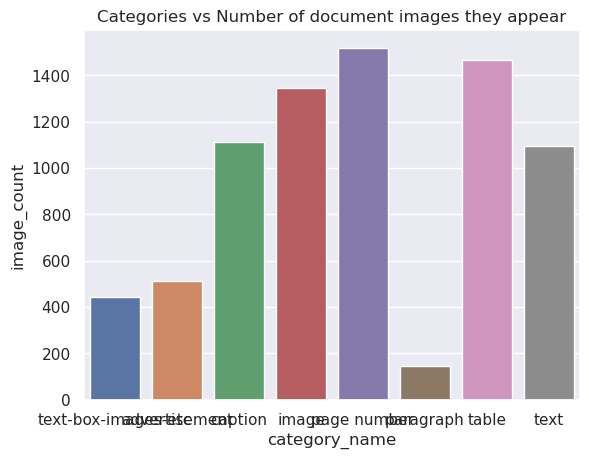

In [22]:
plt.title("Categories vs Number of document images they appear")
sns.barplot(x=categorywise_image_count['category_name'], y=categorywise_image_count['image_count'])

# **Category Wise Graph**

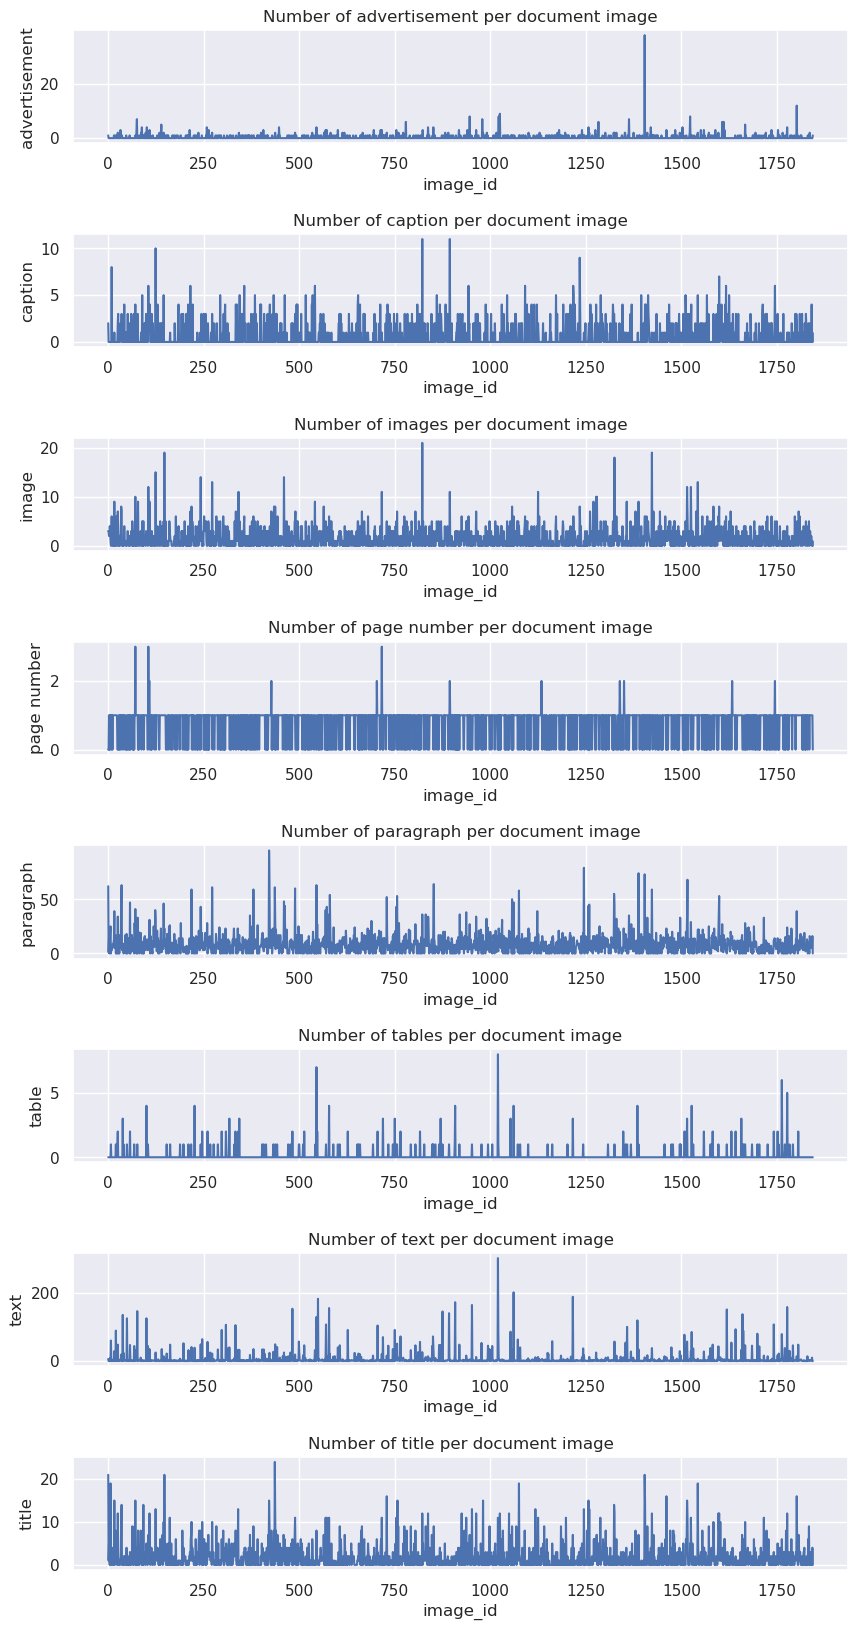

In [23]:
imagewise_category_count=img_cat_count.groupby('image_id', as_index=False)[['advertisement', 'caption', 'image', 'page number', 'paragraph', 'table', 'text', 'title']].sum()
imagewise_category_count.head()

plt.figure(figsize=(10, 20))
plt.subplot(811)
plt.title("Number of advertisement per document image")
sns.lineplot(x=imagewise_category_count['image_id'], y=imagewise_category_count['advertisement'])

plt.subplot(812)
plt.title("Number of caption per document image")
sns.lineplot(x=imagewise_category_count['image_id'], y=imagewise_category_count['caption'])

plt.subplot(813)
plt.title("Number of images per document image")
sns.lineplot(x=imagewise_category_count['image_id'], y=imagewise_category_count['image'])

plt.subplot(814)
plt.title("Number of page number per document image")
sns.lineplot(x=imagewise_category_count['image_id'], y=imagewise_category_count['page number'])

plt.subplot(815)
plt.title("Number of paragraph per document image")
sns.lineplot(x=imagewise_category_count['image_id'], y=imagewise_category_count['paragraph'])

plt.subplot(816)
plt.title("Number of tables per document image")
sns.lineplot(x=imagewise_category_count['image_id'], y=imagewise_category_count['table'])

plt.subplot(817)
plt.title("Number of text per document image")
sns.lineplot(x=imagewise_category_count['image_id'], y=imagewise_category_count['text'])

plt.subplot(818)
plt.title("Number of title per document image")
sns.lineplot(x=imagewise_category_count['image_id'], y=imagewise_category_count['title'])

plt.subplots_adjust(hspace=0.8)

# **Train Dataset Spliting for Validation Dataset**

In [24]:
TRAIN_SPLIT = 0.85

# **Validation Dataset**

In [25]:
n_dataset = len(train_metadata)
n_train = int(n_dataset * TRAIN_SPLIT)
print("n_dataset", n_dataset, "n_train", n_train, "n_val", n_dataset-n_train)

np.random.seed(SEED)

inds = np.random.permutation(n_dataset)
train_inds, valid_inds = inds[:n_train], inds[n_train:]

n_dataset 1845 n_train 1568 n_val 277


# **Converting COCO format to DETECTRON2 Format**

In [26]:
def convert_coco_to_detectron2_format(
    imgdir: Path,
    metadata_df: pd.DataFrame,
    annot_df: Optional[pd.DataFrame] = None,
    target_indices: Optional[np.ndarray] = None,
):

    dataset_dicts = []
    for _, train_meta_row in tqdm(metadata_df.iterrows(), total=len(metadata_df)):
        # Iterate over each image
        image_id, filename, width, height = train_meta_row.values

        annotations = []

        # If train/validation data, then there will be annotations
        if annot_df is not None:
            for _, ann in annot_df.query("image_id == @image_id").iterrows():
                # Get annotations of current iteration's image
                class_id = ann["category_id"]
                gt_masks = ann["gt_masks"]
                bbox_resized = [
                    float(ann["x_min"]),
                    float(ann["y_min"]),
                    float(ann["x_max"]),
                    float(ann["y_max"]),
                ]

                annotation = {
                    "bbox": bbox_resized,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": gt_masks,
                    "category_id": class_id,
                }

                annotations.append(annotation)

        # coco format -> detectron2 format dict
        record = {
            "file_name": str(imgdir/filename),
            "image_id": image_id,
            "width": width,
            "height": height,
            "annotations": annotations
        }

        dataset_dicts.append(record)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

# **Data Registering**

In [27]:
DATA_REGISTER_TRAINING = "fydp_train"
DATA_REGISTER_VALID    = "fydp_valid"
DATA_REGISTER_TEST     = "fydp_test"

# **Register Training Data**

In [28]:
if is_train:
    DatasetCatalog.register(
        DATA_REGISTER_TRAINING,
        lambda: convert_coco_to_detectron2_format(
            TRAIN_IMG_DIR,
            train_metadata,
            train_annot_df,
            target_indices=train_inds,
        ),
    )

    # Set Training data categories
    MetadataCatalog.get(DATA_REGISTER_TRAINING).set(thing_classes=thing_classes)

    dataset_dicts_train = DatasetCatalog.get(DATA_REGISTER_TRAINING)
    metadata_dicts_train = MetadataCatalog.get(DATA_REGISTER_TRAINING)

    print("dicts training size=", len(dataset_dicts_train))

  0%|          | 0/1845 [00:00<?, ?it/s]

dicts training size= 1568


# **Register Validation Data**

In [29]:
if is_train or is_evaluate:
    DatasetCatalog.register(
        DATA_REGISTER_VALID,
        lambda: convert_coco_to_detectron2_format(
            TRAIN_IMG_DIR,
            train_metadata,
            train_annot_df,
            target_indices=valid_inds,
        ),
    )

    # Set Validation data categories
    MetadataCatalog.get(DATA_REGISTER_VALID).set(thing_classes=thing_classes)

    dataset_dicts_valid = DatasetCatalog.get(DATA_REGISTER_VALID)
    metadata_dicts_valid = MetadataCatalog.get(DATA_REGISTER_VALID)

    print("dicts valid size=", len(dataset_dicts_valid))

  0%|          | 0/1845 [00:00<?, ?it/s]

dicts valid size= 277


# **Register Test/Inference Data**

In [30]:
DatasetCatalog.register(
    DATA_REGISTER_TEST,
    lambda: convert_coco_to_detectron2_format(
        TEST_IMG_DIR,
        test_metadata,
    )
)

# Set Test data categories
MetadataCatalog.get(DATA_REGISTER_TEST).set(thing_classes=thing_classes_test)

dataset_dicts_test = DatasetCatalog.get(DATA_REGISTER_TEST)
metadata_dicts_test = MetadataCatalog.get(DATA_REGISTER_TEST)

print("dicts valid size=", len(dataset_dicts_test))

  0%|          | 0/322 [00:00<?, ?it/s]

dicts valid size= 322


# **Training Configuration**

In [31]:
if is_train:
    cfg = get_cfg()

    #config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
    config_name = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

    cfg.merge_from_file(model_zoo.get_config_file(config_name))

    cfg.DATASETS.TRAIN = (DATA_REGISTER_TRAINING,)
    cfg.DATASETS.TEST = (DATA_REGISTER_VALID,)

    # to evaluate during training, you have to implement `build_evaluator()` method of the trainer.
    #!git clone https://github.com/facebookresearch/detectron2/blob/94113be6e12db36b8c7601e13747587f19ec92fe/detectron2/engine/defaults.py#L561
    cfg.TEST.EVAL_PERIOD = 500

    cfg.DATALOADER.NUM_WORKERS = 4

    # cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
    if (is_resume_training):
        print("#### SETTING PRETRAINED WEIGHTS TO RESUME TRAINING ####")
        cfg.MODEL.WEIGHTS = str(PRETRAINED_PATH)
    else:
        print("#### TRAINING MODEL FROM SCRATCH ####")

    cfg.SOLVER.AMP.ENABLED = True
    cfg.SOLVER.IMS_PER_BATCH = 16
    cfg.SOLVER.BASE_LR = 0.001

    cfg.SOLVER.WARMUP_ITERS = 5

    # Maximum number of iterations
    cfg.SOLVER.MAX_ITER = 5000

    cfg.SOLVER.STEPS = (500, 1000) # must be less than MAX_ITER

    cfg.SOLVER.GAMMA = 0.05

    # Small value == Frequent save need a lot of storage.
    cfg.SOLVER.CHECKPOINT_PERIOD = 500
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9

    # Create Output Directory
    cfg.OUTPUT_DIR = str(OUTPUT_DIR)
    print("creating cfg.OUTPUT_DIR -> ", cfg.OUTPUT_DIR)
    OUTPUT_DIR.mkdir(exist_ok=True)
    cfg.INPUT.MIN_SCALE_TRAIN = 0.8                  # Minimum scaling factor
    cfg.INPUT.MAX_SCALE_TRAIN = 1.2                  # Maximum scaling factor

    cfg.INPUT.PIXEL_MEAN = [0.485, 0.456, 0.406]     # Mean pixel values of the dataset
    cfg.INPUT.PIXEL_STD = [0.229, 0.224, 0.225]      # Standard deviation of pixel values
    cfg.INPUT.HORIZONTAL_FLIP = 0.5                  # Probability of horizontal flipping
    cfg.INPUT.VERTICAL_FLIP = 0.2                    # Probability of vertical flipping
    cfg.INPUT.RANDOM_TRANSLATION = (0.0, 0.0)        # Maximum translation in fraction of image size
    cfg.INPUT.CROP.TYPE = "relative_range"
    cfg.INPUT.CROP.SIZE = [0.9, 0.9]                 # Crop size range

    cfg.INPUT.BRIGHTNESS_RANGE = (0.8, 1.2)          # Range of brightness adjustment
    cfg.INPUT.CONTRAST_RANGE = (0.8, 1.2)            # Range of contrast adjustment
    cfg.INPUT.SATURATION_RANGE = (0.8, 1.2)          # Range of saturation adjustment
    cfg.INPUT.HUE_RANGE = (-0.1, 0.1)                # Range of hue adjustment

#### TRAINING MODEL FROM SCRATCH ####
creating cfg.OUTPUT_DIR ->  output


# **Train**

In [32]:
if is_train:
    trainer = DefaultTrainer(cfg) if not is_augment else AugTrainer(cfg)
        
    trainer.resume_or_load(resume=is_resume_training)

    trainer.train()
    
    print("#### TRAINING COMPLETE ####")
    _ = trainer.model.train(False)  # turn off training
    
    FileLink(str(OUTPUT_MODEL))

[02/18 14:17:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 14:17:41 d2.data.build]: Removed 0 images with no usable annotations. 1568 images left.
[02/18 14:17:42 d2.data.build]: Distribution of instances among all 9 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| text-box-im.. | 0            | advertisement | 585          |  caption   | 1011         |
|     image     | 2505         |  page number  | 1167         | paragraph  | 14239        |
|     table     | 208          |     text      | 10676        |   title    | 2986         |
|               |              |               |              |            |              |
|     total     | 33377        |               |              |            |              |
[02/18 14:17:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sampl

R-101.pkl: 179MB [00:01, 166MB/s]                             


[02/18 14:17:43 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[02/18 14:17:43 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105
[02/18 14:17:43 d2.engine.train_loop]: Starting training from iteration 0
[02/18 14:18:21 d2.utils.events]:  eta: 2:19:07  iter: 19  total_loss: 2.857  loss_cls: 0.8975  loss_box_reg: 0.1217  loss_mask: 0.5641  loss_rpn_cls: 0.6335  loss_rpn_loc: 0.5069    time: 1.6495  last_time: 1.6774  data_time: 0.1464  last_data_time: 0.1261   lr: 0.001  max_mem: 7405M
[02/18 14:19:02 d2.utils.events]:  eta: 2:20:55  iter: 39  total_loss: 2.241  loss_cls: 0.5688  loss_box_reg: 0.2758  loss_mask: 0.4659  loss_rpn_cls: 0.4773  loss_rpn_loc: 0.4032    time: 1.6945  last_time: 1.7560  data_time: 0.1393  last_data_time: 0.1463   lr: 0.001  max_mem: 7408M
[02/18 14:19:37 d2.utils.events]:  eta: 2:21:25  iter: 59  total_loss: 2.056  loss_cls: 0.4975  loss_box_reg: 0.3329  loss_mask: 0.4488  loss_rpn_cl

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 14:33:28 d2.data.build]: Distribution of instances among all 9 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| text-box-im.. | 0            | advertisement | 120          |  caption   | 186          |
|     image     | 496          |  page number  | 196          | paragraph  | 2314         |
|     table     | 25           |     text      | 1439         |   title    | 548          |
|               |              |               |              |            |              |
|     total     | 5324         |               |              |            |              |
[02/18 14:33:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 14:33:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 14:49:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 14:49:09 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/18 14:49:09 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/18 14:49:09 d2.data.common]: Serialized dataset takes 1.38 MiB
WARNING [02/18 14:49:09 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[02/18 14:49:09 d2.utils.events]:  eta: 2:04:21  iter: 999  total_loss: 1.42  loss_cls: 0.3177  loss_box_reg: 0.4996  loss_mask: 0.3179  loss_rpn_cls: 0.07625  loss_rpn_loc: 0.2215    time: 1.8565  last_time: 1.8933  data_time: 0.1421  last_data_time: 0.1423   lr: 5e-05  max_mem: 7604M
[02/18 14:49:46 d2.utils.events]:  eta: 2:03:47  iter: 1019  total_loss: 1.416  loss_cls: 0.3254

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 15:04:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 15:04:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/18 15:04:52 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/18 15:04:52 d2.data.common]: Serialized dataset takes 1.38 MiB
WARNING [02/18 15:04:52 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[02/18 15:04:52 d2.utils.events]:  eta: 1:48:59  iter: 1499  total_loss: 1.419  loss_cls: 0.3216  loss_box_reg: 0.4955  loss_mask: 0.32  loss_rpn_cls: 0.07585  loss_rpn_loc: 0.214    time: 1.8599  last_time: 1.9089  data_time: 0.1490  last_data_time: 0.1253   lr: 2.5e-06  max_mem: 7604M
[02/18 15:05:30 d2.utils.events]:  eta: 1:48:22  iter: 1519  total_loss: 1.439  loss_cls: 0.326

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 15:20:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 15:20:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/18 15:20:44 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/18 15:20:44 d2.data.common]: Serialized dataset takes 1.38 MiB
WARNING [02/18 15:20:44 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[02/18 15:20:44 d2.utils.events]:  eta: 1:34:07  iter: 1999  total_loss: 1.433  loss_cls: 0.3313  loss_box_reg: 0.4908  loss_mask: 0.313  loss_rpn_cls: 0.0767  loss_rpn_loc: 0.2102    time: 1.8660  last_time: 1.9014  data_time: 0.1464  last_data_time: 0.1384   lr: 2.5e-06  max_mem: 7604M
[02/18 15:21:22 d2.utils.events]:  eta: 1:33:30  iter: 2019  total_loss: 1.46  loss_cls: 0.323

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 15:36:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 15:36:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/18 15:36:37 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/18 15:36:37 d2.data.common]: Serialized dataset takes 1.38 MiB
WARNING [02/18 15:36:37 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[02/18 15:36:37 d2.utils.events]:  eta: 1:18:41  iter: 2499  total_loss: 1.425  loss_cls: 0.333  loss_box_reg: 0.5047  loss_mask: 0.3175  loss_rpn_cls: 0.08481  loss_rpn_loc: 0.2132    time: 1.8702  last_time: 1.8568  data_time: 0.1519  last_data_time: 0.1365   lr: 2.5e-06  max_mem: 7604M
[02/18 15:37:15 d2.utils.events]:  eta: 1:18:03  iter: 2519  total_loss: 1.43  loss_cls: 0.31

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 15:52:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 15:52:29 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/18 15:52:29 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/18 15:52:29 d2.data.common]: Serialized dataset takes 1.38 MiB
WARNING [02/18 15:52:29 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[02/18 15:52:29 d2.utils.events]:  eta: 1:02:56  iter: 2999  total_loss: 1.391  loss_cls: 0.3071  loss_box_reg: 0.4857  loss_mask: 0.3099  loss_rpn_cls: 0.07849  loss_rpn_loc: 0.2237    time: 1.8727  last_time: 1.8709  data_time: 0.1467  last_data_time: 0.1375   lr: 2.5e-06  max_mem: 7604M
[02/18 15:53:07 d2.utils.events]:  eta: 1:02:18  iter: 3019  total_loss: 1.455  loss_cls: 0.

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 16:08:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 16:08:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/18 16:08:20 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/18 16:08:20 d2.data.common]: Serialized dataset takes 1.38 MiB
WARNING [02/18 16:08:20 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[02/18 16:08:20 d2.utils.events]:  eta: 0:47:11  iter: 3499  total_loss: 1.402  loss_cls: 0.3181  loss_box_reg: 0.4866  loss_mask: 0.3125  loss_rpn_cls: 0.08556  loss_rpn_loc: 0.2129    time: 1.8741  last_time: 1.8801  data_time: 0.1504  last_data_time: 0.1389   lr: 2.5e-06  max_mem: 7604M
[02/18 16:08:58 d2.utils.events]:  eta: 0:46:34  iter: 3519  total_loss: 1.4  loss_cls: 0.31

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 16:24:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 16:24:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/18 16:24:11 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/18 16:24:11 d2.data.common]: Serialized dataset takes 1.38 MiB
WARNING [02/18 16:24:11 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[02/18 16:24:11 d2.utils.events]:  eta: 0:31:30  iter: 3999  total_loss: 1.463  loss_cls: 0.3225  loss_box_reg: 0.4904  loss_mask: 0.3253  loss_rpn_cls: 0.08782  loss_rpn_loc: 0.2272    time: 1.8754  last_time: 1.9367  data_time: 0.1515  last_data_time: 0.1797   lr: 2.5e-06  max_mem: 7604M
[02/18 16:24:50 d2.utils.events]:  eta: 0:30:52  iter: 4019  total_loss: 1.413  loss_cls: 0.

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 16:40:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 16:40:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/18 16:40:06 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/18 16:40:06 d2.data.common]: Serialized dataset takes 1.38 MiB
WARNING [02/18 16:40:06 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[02/18 16:40:06 d2.utils.events]:  eta: 0:15:44  iter: 4499  total_loss: 1.424  loss_cls: 0.3226  loss_box_reg: 0.4899  loss_mask: 0.3126  loss_rpn_cls: 0.06693  loss_rpn_loc: 0.2098    time: 1.8770  last_time: 1.6842  data_time: 0.1572  last_data_time: 0.1593   lr: 2.5e-06  max_mem: 7604M
[02/18 16:40:44 d2.utils.events]:  eta: 0:15:06  iter: 4519  total_loss: 1.4  loss_cls: 0.31

  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 16:56:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 16:56:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/18 16:56:01 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/18 16:56:02 d2.data.common]: Serialized dataset takes 1.38 MiB
WARNING [02/18 16:56:02 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
#### TRAINING COMPLETE ####


# **Training Result**

                                     0            1            2            3  \
data_time                     0.132051     0.134231     0.132036     0.135996   
eta_seconds                8347.384413  8455.900266  8485.208945  8644.447766   
fast_rcnn/cls_accuracy        0.841309     0.831787     0.850098     0.843018   
fast_rcnn/false_negative      0.965909     0.990794     0.848070     0.649447   
fast_rcnn/fg_cls_accuracy     0.000000     0.009206     0.137455     0.287281   
iteration                    19.000000    39.000000    59.000000    79.000000   
loss_box_reg                  0.121728     0.275790     0.332859     0.465429   
loss_cls                      0.897533     0.568804     0.497549     0.473744   
loss_mask                     0.564145     0.465883     0.448780     0.465654   
loss_rpn_cls                  0.633474     0.477340     0.346644     0.276062   
loss_rpn_loc                  0.506851     0.403219     0.380927     0.385941   
lr                          

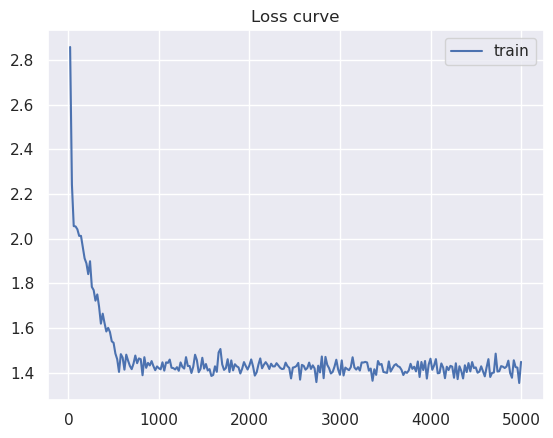

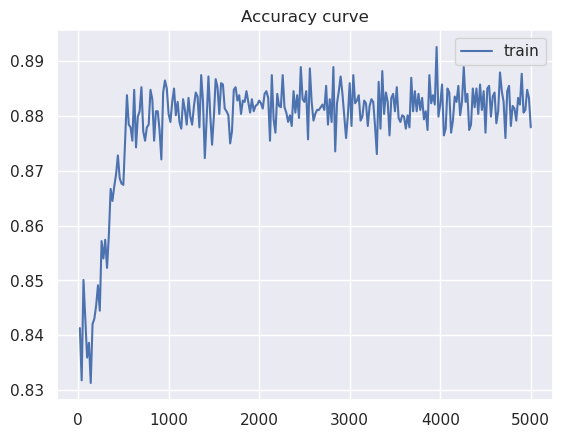

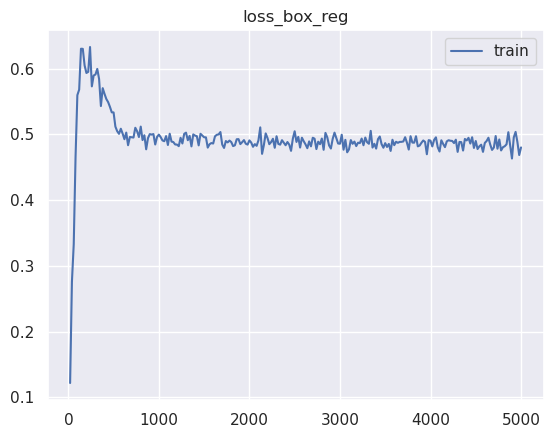

In [33]:
if is_train:
    # Load metrics
    metrics_df = pd.read_json(
        OUTPUT_DIR/"metrics.json", orient="records", lines=True
    )
    mdf = metrics_df.sort_values("iteration")
    print(mdf.head(10).T)

    # Plot loss
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["total_loss"].isna()]
    ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")

    if "validation_loss" in mdf.columns:
        mdf2 = mdf[~mdf["validation_loss"].isna()]
        ax.plot(mdf2["iteration"], mdf2["validation_loss"],
                c="C1", label="validation")

    ax.legend()
    ax.set_title("Loss curve")
    plt.show()

    # Plot Accuracy
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
    ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"],
            c="C0", label="train")

    ax.legend()
    ax.set_title("Accuracy curve")
    plt.show()

    # Plot Bounding Box regressor loss
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["loss_box_reg"].isna()]
    ax.plot(mdf1["iteration"], mdf1["loss_box_reg"], c="C0", label="train")

    ax.legend()
    ax.set_title("loss_box_reg")
    plt.show()

# **Evaluation On Validation Set**

In [34]:
evaluator = COCOEvaluator(DATA_REGISTER_VALID, cfg, False, output_dir="./output/")

cfg.MODEL.WEIGHTS = str(MODEL_PATH)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
cfg.INPUT.MASK_FORMAT='polygon'

val_loader = build_detection_test_loader(cfg, DATA_REGISTER_VALID)
inference_on_dataset(trainer.model, val_loader, evaluator)

[02/18 16:56:03 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [02/18 16:56:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/18 16:56:03 d2.evaluation.coco_evaluation]: Trying to convert 'fydp_valid' to COCO format ...
[02/18 16:56:03 d2.data.datasets.coco]: Converting annotations of dataset 'fydp_valid' to COCO format ...)


  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 16:56:12 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/18 16:56:13 d2.data.datasets.coco]: Conversion finished, #images: 277, #annotations: 5324
[02/18 16:56:13 d2.data.datasets.coco]: Caching COCO format annotations at './output/fydp_valid_coco_format.json' ...


  0%|          | 0/1845 [00:00<?, ?it/s]

[02/18 16:56:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/18 16:56:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/18 16:56:21 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/18 16:56:21 d2.data.common]: Serialized dataset takes 1.38 MiB
[02/18 16:56:21 d2.evaluation.evaluator]: Start inference on 277 batches
[02/18 16:56:24 d2.evaluation.evaluator]: Inference done 11/277. Dataloading: 0.0013 s/iter. Inference: 0.1329 s/iter. Eval: 0.0959 s/iter. Total: 0.2301 s/iter. ETA=0:01:01
[02/18 16:56:29 d2.evaluation.evaluator]: Inference done 35/277. Dataloading: 0.0016 s/iter. Inference: 0.1312 s/iter. Eval: 0.0821 s/iter. Total: 0.2151 s/iter. ETA=0:00:52
[02/18 16:56:34 d2.evaluation.evaluator]: Inference done 61/277. Dataloading: 0.0017 s/iter. Inference: 0.1300

OrderedDict([('bbox',
              {'AP': 24.892036759695337,
               'AP50': 48.37220214101741,
               'AP75': 22.11521305270039,
               'APs': 17.393402175620782,
               'APm': 19.038189169570032,
               'APl': 19.597752547889378,
               'AP-text-box-images-etc': nan,
               'AP-advertisement': 5.765275752316934,
               'AP-caption': 26.734027064185504,
               'AP-image': 45.479723959375576,
               'AP-page number': 28.60832927931698,
               'AP-paragraph': 51.17946557129888,
               'AP-table': 0.0,
               'AP-text': 18.09761376002558,
               'AP-title': 23.271858691043214}),
             ('segm',
              {'AP': 23.62707532438238,
               'AP50': 48.0834290918363,
               'AP75': 19.962839514902374,
               'APs': 15.576229696074162,
               'APm': 18.74017821701443,
               'APl': 19.64030598116471,
               'AP-text-box-image

# **Set Acceptance Threshold**

In [35]:
ACCEPTANCE_THRESHOLD = 0.6  

# **Set Model For Prediction**

In [ ]:
print(f"#### MODEL: {inf_cfg.MODEL.WEIGHTS} FOR INFERENCE ####")
predictor = DefaultPredictor(inf_cfg)

# **Prediction (Sample Segmentations)**

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
indices = [ax[0][0], ax[1][0], ax[0][1], ax[1][1]]

# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 4
samples = np.random.choice(dataset_dicts_test, NUM_TEST_SAMPLES)

for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=metadata_dicts_test, scale=0.5,)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu")
    )
    display_img = visualizer.get_image()[:, :, ::-1]
    indices[i].grid(False)
    indices[i].imshow(display_img)